## initial setup

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path
import pandas as pd
from google.oauth2 import service_account
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from scipy import stats, ndimage, interpolate
from sklearn.preprocessing import StandardScaler
import google.auth
warnings.filterwarnings('ignore')  # Suppresses all warnings

# Add parent directory to Python path for local imports
notebook_path = Path.cwd()
project_root = notebook_path.parent  # Changed from parent.parent to just parent
sys.path.insert(0, str(project_root))  # Changed append to insert(0) for priority

# Local application imports
from src.mimicdf import MIMICDF
from src.preprocessing.data_preprocessor import DataPreprocessor

# Initialize MIMIC database connection to GCP
mimicdf = MIMICDF.create_connection()

# Initialize MIMIC demo database
# mimicdf = MIMICDF.create_demo()

Successfully connected to MIMIC-IV ED dataset


In [2]:

ed_data = mimicdf.ed_data()
# Preprocess ed_data to handle invlaid values
data_preprocessor = DataPreprocessor(ed_data)
model_data = data_preprocessor.prepare_data()
model_data.describe().T

Loading edstays...
Table loaded: edstays
Loading demographics...
Table loaded: edstays
Table loaded: age
Loading age data...
Table loaded: age
Calculating ED visit age...
Merging time features...
Table loaded: edstays
Merging triage features...
Table loaded: triage
Cleaning up columns...

 Dataframe shape: (425087, 18) 

Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   subject_id         425087 non-null  Int64  
 1   stay_id            425087 non-null  Int64  
 2   gender             425087 non-null  object 
 3   arrival_transport  425087 non-null  object 
 4   disposition        425087 non-null  object 
 5   race               425087 non-null  object 
 6   age_at_ed          316465 non-null  Int64  
 7   dow                425087 non-null  object 
 8   hour               425087 non-null  int32  
 9   los_

,count,mean,std,min,25%,50%,75%,max
subject_id,351866.0,15008855.205905,2881506.694845,10000032.0,12517159.0,15013868.0,17507655.0,19999828.0
stay_id,351866.0,34998327.22622,2887903.477755,30000012.0,32499735.75,34993051.0,37506972.5,39999964.0
hour,351866.0,13.471461,5.821292,0.0,10.0,14.0,18.0,23.0
los_minutes,351866.0,428.446211,365.069948,2.0,220.0,334.0,501.0,10956.333333
temperature,351866.0,98.085923,1.003169,56.0,97.6,98.0,98.6,111.4
heartrate,351866.0,84.805593,17.330396,24.0,72.0,83.0,96.0,250.0
resprate,351866.0,17.510433,2.366275,6.0,16.0,18.0,18.0,209.0
o2sat,351866.0,98.447081,1.949135,42.0,97.0,99.0,100.0,100.0
sbp,351866.0,135.268227,22.099619,50.0,120.0,133.0,148.0,312.0
dbp,351866.0,77.511939,14.574139,21.0,68.0,77.0,87.0,214.0


Box-Cox lambda parameter for los_minutes: -0.025


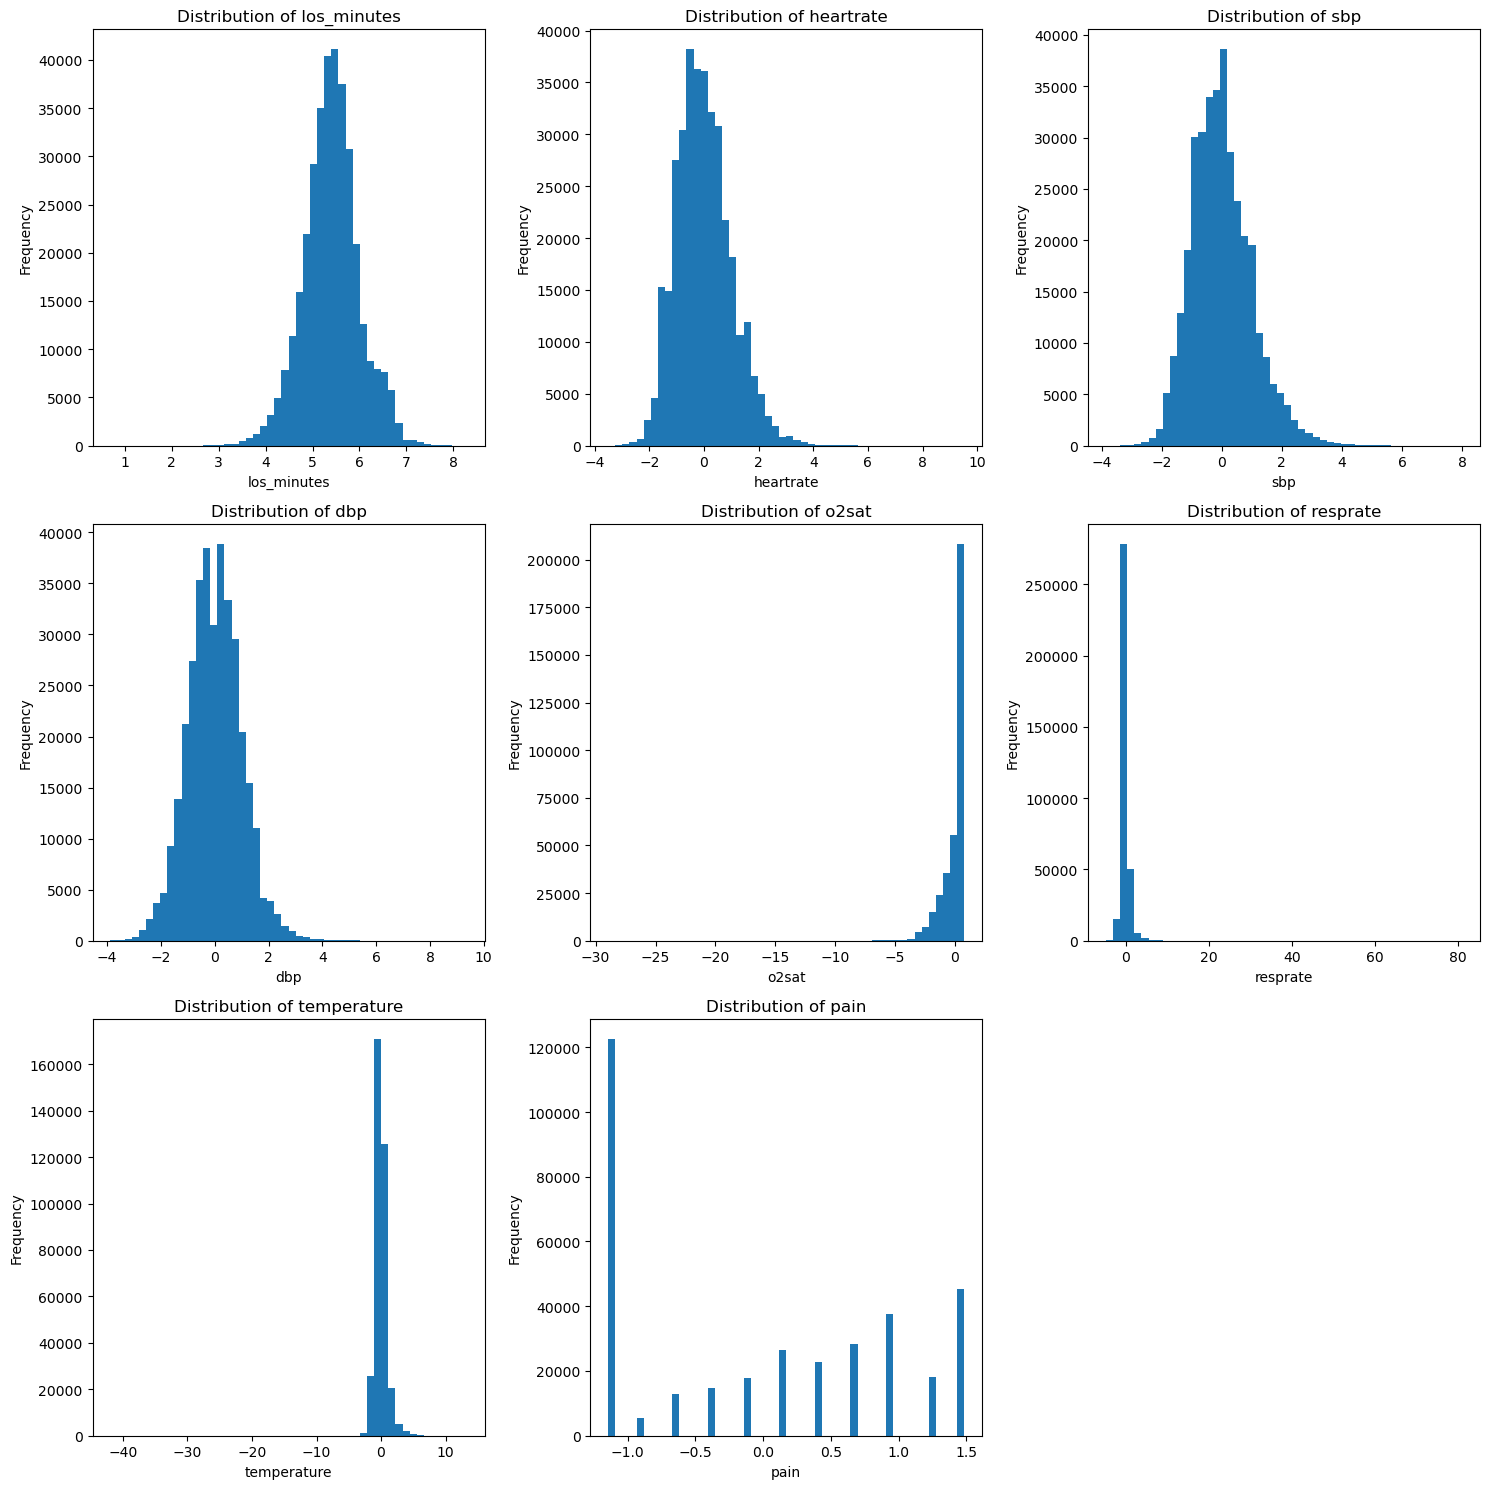


Basic statistics of transformed features:
       los_minutes   heartrate         sbp         dbp       o2sat  \
count   351866.000  351866.000  351866.000  351866.000  351866.000   
mean         5.404      -0.000      -0.000      -0.000       0.000   
std          0.592       1.000       1.000       1.000       1.000   
min          0.687      -3.509      -3.858      -3.878     -28.960   
25%          5.042      -0.739      -0.691      -0.653      -0.742   
50%          5.405      -0.104      -0.103      -0.035       0.284   
75%          5.753       0.646       0.576       0.651       0.797   
max          8.289       9.532       7.997       9.365       0.797   

         resprate  temperature        pain  
count  351866.000   351866.000  351866.000  
mean       -0.000        0.000      -0.000  
std         1.000        1.000       1.000  
min        -4.864      -41.953      -1.144  
25%        -0.638       -0.484      -1.144  
50%         0.207       -0.086       0.171  
75%        

In [4]:
def transform_model_data(model_data, features=None, plot=True):
    """
    Transform model data by applying Box-Cox transformation to los_minutes
    and standardizing other features.
    
    Args:
        model_data (pd.DataFrame): Input DataFrame containing the features
        features (list): List of features to transform. If None, uses default features
        plot (bool): Whether to plot feature distributions
    
    Returns:
        pd.DataFrame: Transformed DataFrame
        float: Lambda parameter from Box-Cox transformation
    """
    # 1. Select features
    if features is None:
        features = ['los_minutes', 'heartrate', 'sbp', 'dbp', 'o2sat', 
                   'resprate', 'temperature', 'pain']
    df_prep = model_data[features].copy()

    # 2. Box-Cox transform los_minutes
    df_prep['los_minutes'], lambda_param = stats.boxcox(df_prep['los_minutes'])
    print(f"Box-Cox lambda parameter for los_minutes: {lambda_param:.3f}")

    # 3. Standard scale all other features
    other_features = [col for col in features if col != 'los_minutes']
    scaler = StandardScaler()
    df_prep[other_features] = scaler.fit_transform(df_prep[other_features])

    # 4. Create histograms if plot=True
    if plot:
        n_features = len(features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.ravel()  # Flatten axes array for easier indexing

        for idx, feature in enumerate(features):
            axes[idx].hist(df_prep[feature], bins=50)
            axes[idx].set_title(f'Distribution of {feature}')
            axes[idx].set_xlabel(feature)
            axes[idx].set_ylabel('Frequency')

        # Remove empty subplots if any
        for idx in range(n_features, len(axes)):
            fig.delaxes(axes[idx])

        plt.tight_layout()
        plt.show()

        # Print basic statistics of transformed data
        print("\nBasic statistics of transformed features:")
        print(df_prep.describe().round(3))

    return df_prep, lambda_param

# Example usage:
df_prep, lambda_param = transform_model_data(model_data)

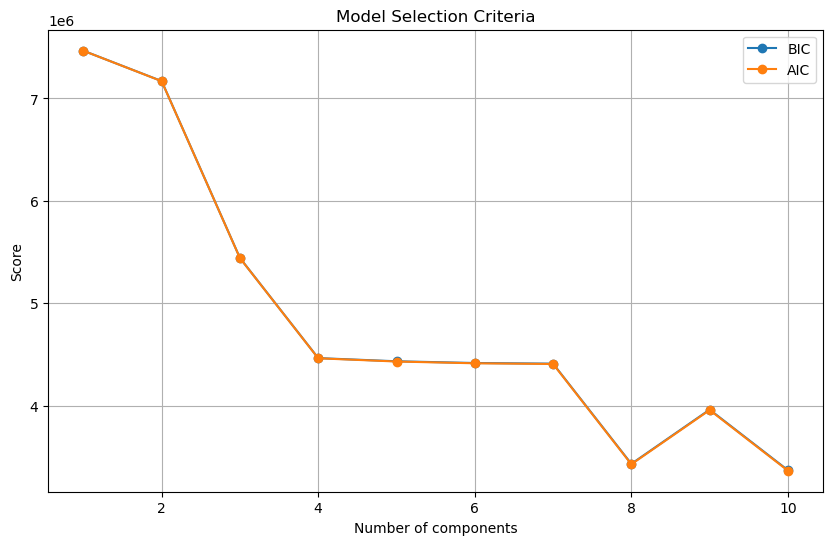

Optimal number of components according to:
BIC: 10
AIC: 10


In [5]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

def analyze_gmm_bic_aic(data, max_components=10):
    """
    Analyze optimal number of GMM components using BIC and AIC.
    
    Args:
        data (pd.DataFrame): Preprocessed data
        max_components (int): Maximum number of components to test
    """
    n_components_range = range(1, max_components + 1)
    bic = []
    aic = []
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, 
                             random_state=42,
                             n_init=5)  # Multiple initializations for stability
        gmm.fit(data)
        bic.append(gmm.bic(data))
        aic.append(gmm.aic(data))
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, bic, label='BIC', marker='o')
    plt.plot(n_components_range, aic, label='AIC', marker='o')
    plt.xlabel('Number of components')
    plt.ylabel('Score')
    plt.title('Model Selection Criteria')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Find optimal number of components
    optimal_n_bic = n_components_range[np.argmin(bic)]
    optimal_n_aic = n_components_range[np.argmin(aic)]
    
    print(f"Optimal number of components according to:")
    print(f"BIC: {optimal_n_bic}")
    print(f"AIC: {optimal_n_aic}")
    
    return bic, aic

# Run the analysis
bic, aic = analyze_gmm_bic_aic(df_prep)